# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 57.0MB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [258]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder ,MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout,LSTM ,GRU
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

In [274]:
df=pd.read_csv("/content/Traffic Data.csv")

In [275]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
 7   date_time            20000 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.2+ MB


In [277]:
df['date_time']=pd.to_datetime(df['date_time'],format='mixed')

In [278]:
df['date_time']

0       2017-08-27 01:00:00
1       2018-09-06 23:00:00
2       2017-08-25 18:00:00
3       2017-11-09 22:00:00
4       2017-11-09 15:00:00
                ...        
19995   2018-06-06 21:00:00
19996   2017-10-25 15:00:00
19997   2018-03-28 23:00:00
19998   2018-02-12 15:00:00
19999   2018-05-31 18:00:00
Name: date_time, Length: 20000, dtype: datetime64[ns]

In [279]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,date_time
count,19980.000000,20000.000000,20000.000000,20000.0,20000.000000,20000
mean,3278.186887,281.162680,0.048396,0.0,49.384600,2017-10-22 04:13:17.939999744
min,113.000000,243.390000,0.000000,0.0,0.000000,2016-11-18 15:00:00
25%,1228.750000,271.950000,0.000000,0.0,1.000000,2017-04-30 14:45:00
50%,3430.000000,281.825000,0.000000,0.0,75.000000,2017-10-21 07:30:00
75%,4928.000000,291.840000,0.000000,0.0,90.000000,2018-04-13 21:00:00
max,16781.000000,310.070000,10.600000,0.0,92.000000,2018-09-30 23:00:00
std,1977.171357,12.661288,0.398007,0.0,39.647341,NaN


In [280]:
df=df.set_index('date_time')

In [281]:
df.sort_index()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Snow,heavy snow
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Fog,fog
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Mist,mist
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Fog,fog
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Mist,mist
...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75,Clouds,broken clouds
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90,Clouds,overcast clouds
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

<Axes: >

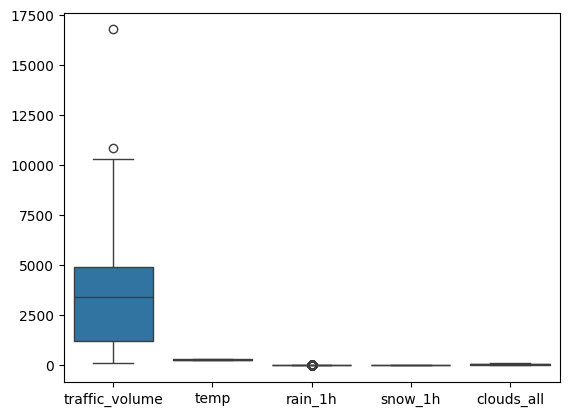

In [282]:
sns.boxplot(df)

In [283]:
df.isna().sum()

traffic_volume         20
temp                    0
rain_1h                 0
snow_1h                 0
clouds_all              0
weather_main            0
weather_description     0
dtype: int64

In [284]:
df.duplicated().sum()

18

In [285]:
df=df.drop_duplicates()

In [286]:
df.duplicated().sum()

0

In [287]:
df['weather_main'].value_counts()

weather_main
Clear           5606
Clouds          5231
Mist            2755
Rain            2244
Snow            1461
Drizzle          992
Haze             672
Thunderstorm     541
Fog              477
Smoke              3
Name: count, dtype: int64

In [288]:
df['weather_description'].value_counts()

weather_description
sky is clear                           5506
mist                                   2755
overcast clouds                        1737
broken clouds                          1573
scattered clouds                       1457
light snow                             1246
light rain                             1201
moderate rain                           747
haze                                    672
light intensity drizzle                 606
fog                                     477
few clouds                              464
proximity thunderstorm                  365
drizzle                                 346
heavy intensity rain                    184
snow                                    160
proximity shower rain                   106
Sky is Clear                            100
thunderstorm                             67
heavy snow                               39
heavy intensity drizzle                  34
proximity thunderstorm with rain         33
thunderstorm

In [289]:
df['traffic_volume'].value_counts()

traffic_volume
353.0     29
340.0     22
358.0     22
373.0     22
344.0     22
          ..
1144.0     1
6245.0     1
1521.0     1
6135.0     1
1132.0     1
Name: count, Length: 5754, dtype: int64

In [290]:
df['traffic_volume'].mean()

3278.1506362087966

In [291]:
df['traffic_volume']=df['traffic_volume'].fillna(df['traffic_volume']).mean()

In [292]:
df.isna().sum()

traffic_volume         0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
dtype: int64

In [293]:

df=df.drop(columns=['rain_1h','snow_1h','clouds_all'],axis=1)

In [294]:
df.head()

,traffic_volume,temp,weather_main,weather_description
date_time,,,,
2017-08-27 01:00:00,3278.150636,291.15,Mist,mist
2018-09-06 23:00:00,3278.150636,286.01,Clear,sky is clear
2017-08-25 18:00:00,3278.150636,293.69,Clouds,broken clouds
2017-11-09 22:00:00,3278.150636,262.35,Clear,sky is clear
2017-11-09 15:00:00,3278.150636,267.08,Clear,sky is clear


## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [295]:
encoder=LabelEncoder()
df['weather_description']=encoder.fit_transform(df['weather_description'])
df['weather_main']=encoder.fit_transform(df['weather_main'])


In [296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19982 entries, 2017-08-27 01:00:00 to 2018-05-31 18:00:00
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19982 non-null  float64
 1   temp                 19982 non-null  float64
 2   weather_main         19982 non-null  int64  
 3   weather_description  19982 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 780.5 KB


TypeError: Index(...) must be called with a collection of some kind, 'seasonal' was passed

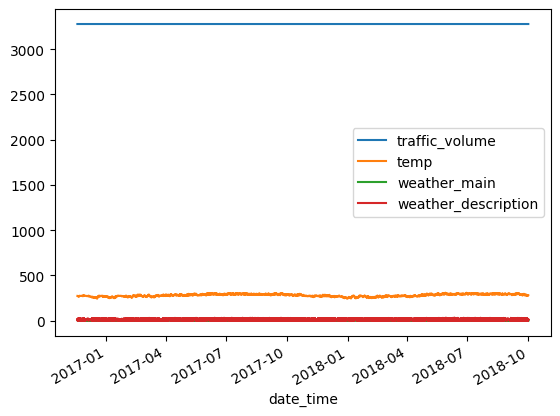

In [302]:
df.plot(kind='line')
seasonal_decompose(df, period=7)

In [ ]:
def remove_outliers(data,col):
  Q1= data.percentile(0.25)
  Q3= data.(0.75)
  IQR= Q3-Q1
  lower_bunddle= Q1 - 1.5 * IQR
  upper_bunddle= Q3 + 1.5 * IQR
  return(data(lower_bunddle>=Q1) & (upper_bunddle<=Q3))

remove_outliers(df,'traffic_volume')

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [228]:
df['prev_traffic_volume']=df['traffic_volume'].shift(1)

In [229]:
df['Day of the week']=df['date_time'].dt.day_name()
df['Month']=df['date_time'].dt.month()
df['Day of the year']=df['date_time'].dt.day_of_year()

KeyError: 'date_time'

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [231]:
scaler=MinMaxScaler(feature_range=(0, 1))
scaled_df=scaler.fit_transform(df)

In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2017-08-27 01:00:00 to 2018-05-31 18:00:00
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       20000 non-null  float64
 1   temp                 20000 non-null  float64
 2   weather_main         20000 non-null  int64  
 3   weather_description  20000 non-null  int64  
 4   prev_traffic_volume  19999 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 937.5 KB


## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [233]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [234]:
seq_length =7
X, y = create_sequences(scaled_df, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [235]:
X_train.shape

(15994, 7, 1)

In [236]:
X_test.shape

(3999, 7, 1)

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [265]:
#LSTM
model=Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)),
    LSTM(units=50, return_sequences=True),
    Dense(units=25),
    Dense(units=1)
])


In [266]:
model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 7, 64)             16896     
                                                                 
 lstm_21 (LSTM)              (None, 7, 50)             23000     
                                                                 
 dense_26 (Dense)            (None, 7, 25)             1275      
                                                                 
 dense_27 (Dense)            (None, 7, 1)              26        
                                                                 
Total params: 41197 (160.93 KB)
Trainable params: 41197 (160.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [267]:
history=model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test,y_test))

Epoch 1/50
500/500 [==============================] - 12s 16ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/50
500/500 [==============================] - 6s 11ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/50
500/500 [==============================] - 6s 11ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/50
500/500 [==============================] - 7s 15ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/50
500/500 [==============================] - 6s 12ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
500/500 [==============================] - 7s 15ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/50
500/500 [==============================] - 6s 12ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/50
500/50

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [240]:
prediction=model.predict(X_test)
prediction = scaler.inverse_transform(prediction.reshape(-1, 1))
y_actual_p = scaler.inverse_transform(y_test.reshape(-1, 1))

125/125 [==============================] - 1s 4ms/step


ValueError: non-broadcastable output operand with shape (27993,1) doesn't match the broadcast shape (27993,5)

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [241]:
scaler.inverse_transform(prediction)
predict_traffic=plt.plot(predict_traffic,color='red',label='predict_traffic')
y_actual_p=plt.plot(y_test,color='blue',label='y_actual_p')

ValueError: Found array with dim 3. None expected <= 2.

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [242]:
#GRU
model2=Sequential([
    GRU(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)),
    GRU(units=50,return_sequences=True),
    Dense(units=25),
    Dense(units=1)
])


In [243]:
model2.compile(optimizer='adam',loss='mean_squared_error')
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 7, 50)             8550      
                                                                 
 gru_10 (GRU)                (None, 7, 50)             15300     
                                                                 
 dense_18 (Dense)            (None, 7, 25)             1275      
                                                                 
 dense_19 (Dense)            (None, 7, 1)              26        
                                                                 
Total params: 25151 (98.25 KB)
Trainable params: 25151 (98.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [244]:
historry=model.fit(X_train,y_train,batch_size=200,epochs=50,validation_data=(X_test,y_test))

Epoch 1/50
80/80 [==============================] - 5s 58ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/50
80/80 [==============================] - 3s 34ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/50
80/80 [==============================] - 3s 34ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/50
80/80 [==============================] - 3s 34ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/50
80/80 [==============================] - 3s 40ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/50
80/80 [==============================] - 4s 49ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
80/80 [==============================] - 3s 34ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/50
80/80 [==============================] - 3s 34ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/50
80/80 [==============================] - 3s 34ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/50
80/80 [==================

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [268]:
prediction2=model2.predict(X_test)
prediction2 = scaler.inverse_transform(prediction2.reshape(-1, 1))
y_actual_p = scaler.inverse_transform(y_test.reshape(-1, 1))

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_9' (type Sequential).
    
    Input 0 of layer "gru_9" is incompatible with the layer: expected shape=(None, None, 5), found shape=(None, 7, 1)
    
    Call arguments received by layer 'sequential_9' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 7, 1), dtype=float32)
      • training=False
      • mask=None


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [269]:
scaler.inverse_transform(prediction2)
predict_traffic=plt.plot(predict_traffic,color='red',label='predict_traffic')
y_actual_p=plt.plot(y_test,color='blue',label='y_actual_p')

ValueError: Found array with dim 3. None expected <= 2.

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

**Data Preprocessing:**
in this section i've used minmax to sc and fillna to fill the missing values in the traffic_volume column
and i've used the labelencoder to deal with the object column like wether description and weather_main ,also change the date_time from object to datetime .

**Feature Engineering:**
in this section i've created the prev_traffic_volume that shift teh traffic_volume and column for month and day of year and the day .

**Model Architecture:**
in this section i worked with LSTM and GRU and both have 4 layers with differnt units numbers i started with bigger number then went smaller and smaller.

**Training Process:**
there is some problem i faced with the training but i couldn't figure out where is the problem

**Loss Function and Metrics:**
mean square error

**Model Tuning (If Done): **
-----


**Overfitting and Underfitting:**
-----

**Future Improvements:**
i would figure out why i faced these errors and solve